In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/top-20-play-store-app-reviews-daily-update/Candy Crush Saga.csv
/kaggle/input/top-20-play-store-app-reviews-daily-update/Twitter.csv
/kaggle/input/top-20-play-store-app-reviews-daily-update/Facebook Lite.csv
/kaggle/input/top-20-play-store-app-reviews-daily-update/Netflix.csv
/kaggle/input/top-20-play-store-app-reviews-daily-update/Instagram.csv
/kaggle/input/top-20-play-store-app-reviews-daily-update/Spotify.csv
/kaggle/input/top-20-play-store-app-reviews-daily-update/Snapchat.csv
/kaggle/input/top-20-play-store-app-reviews-daily-update/SHAREit.csv
/kaggle/input/top-20-play-store-app-reviews-daily-update/Facebook.csv
/kaggle/input/top-20-play-store-app-reviews-daily-update/LINE.csv
/kaggle/input/top-20-play-store-app-reviews-daily-update/WhatsApp.csv
/kaggle/input/top-20-play-store-app-reviews-daily-update/Facebook Messenger.csv
/kaggle/input/top-20-play-store-app-reviews-daily-update/Flipboard.csv
/kaggle/input/top-20-play-store-app-reviews-daily-update/Microsoft Word.c

# Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
import plotly.express as px
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import re
import emoji
from gensim.utils import simple_preprocess
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Importing the Dataset

In [3]:
df = pd.read_csv('/kaggle/input/top-20-play-store-app-reviews-daily-update/all_combined.csv')
df.head()

reviewId  \
0  ad79684f-5763-4cc4-b730-a664c56917f5   
1  7413ce9a-5fdb-43fe-885e-d7e97e6f74dd   
2  89d84e8d-edb4-4953-ad51-21a4e6e2c860   
3  69d2af5c-2e31-4f11-9afa-6af656bef5bc   
4  f8b343c0-c587-4eda-b22c-4a09f7760e11   

                                            content  score       app  
0                                          Nice app      3  Facebook  
1                                              Nice      5  Facebook  
2                                     Joss app🌸☺️💖✨      5  Facebook  
3                         Rnju Rnju 12345-789 Bcdgh      4  Facebook  
4  I am very poor butt this app is my future career      5  Facebook

In [4]:
print(df.shape)
print(df.dtypes)
print(df.describe())

(200000, 4)
reviewId    object
content     object
score        int64
app         object
dtype: object
               score
count  200000.000000
mean        3.782790
std         1.644534
min         1.000000
25%         2.000000
50%         5.000000
75%         5.000000
max         5.000000


# Dropping Null

In [5]:
print(df.isnull().sum())
# If there are missing values, drop or impute them based on the use case
df = df.dropna()

reviewId     0
content     12
score        0
app          0
dtype: int64


# Distribution of the Rating score

In [6]:
fig = px.histogram(df, x='score', nbins=20, title='Distribution of Rating Scores')
fig.update_layout(xaxis_title='Score', yaxis_title='Frequency')
fig.show()

# Sentiment Analysis

In [7]:
# Install a sentiment analysis library, such as TextBlob or NLTK
df['sentiment'] = df['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [8]:
fig = px.box(df, x='app', y='sentiment', title='Sentiment Analysis by App')
fig.update_layout(xaxis_title='App', yaxis_title='Sentiment Polarity')
fig.show()


# Text Pre-processing

In [9]:
def preprocess(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove emojis
    text = emoji_pattern.sub(r'', text)
    # Remove non-alphanumeric characters
    text = re.sub(r'[^0-9a-zA-Z\s]', '', text)
    # Convert to lowercase and tokenize
    tokens = [token.lower() for token in simple_preprocess(text) if token not in gensim.parsing.preprocessing.STOPWORDS]
    return tokens

# Define a regular expression pattern to remove emojis
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"  # other miscellaneous symbols
        u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

# Tokenization

In [10]:
# Preprocess the text data
df['tokens'] = df['content'].apply(preprocess)

# Create a dictionary of the tokens
dictionary = Dictionary(df['tokens'])

# Convert the tokens to a bag-of-words representation
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Train an LDA model with 10 topics
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)

# Print the top 10 words for each topic
for topic in lda_model.show_topics(num_topics=10, num_words=10):
    print(topic)

(0, '0.070*"bad" + 0.052*"application" + 0.039*"amazing" + 0.025*"cool" + 0.018*"bisa" + 0.018*"downloaded" + 0.017*"pls" + 0.014*"wow" + 0.013*"tidak" + 0.011*"ada"')
(1, '0.136*"love" + 0.125*"app" + 0.091*"best" + 0.035*"bluetooth" + 0.023*"experience" + 0.021*"free" + 0.017*"customer" + 0.015*"sound" + 0.015*"media" + 0.013*"photo"')
(2, '0.111*"ok" + 0.093*"apps" + 0.079*"excellent" + 0.069*"like" + 0.054*"game" + 0.039*"slow" + 0.018*"gb" + 0.017*"multiple" + 0.015*"upgrade" + 0.014*"opening"')
(3, '0.645*"good" + 0.028*"lost" + 0.026*"fun" + 0.011*"listening" + 0.009*"saved" + 0.009*"youtube" + 0.007*"needed" + 0.006*"theyre" + 0.006*"changes" + 0.006*"rubbish"')
(4, '0.064*"account" + 0.053*"code" + 0.034*"number" + 0.031*"password" + 0.029*"login" + 0.027*"email" + 0.027*"log" + 0.025*"help" + 0.025*"service" + 0.023*"awesome"')
(5, '0.191*"nice" + 0.110*"app" + 0.050*"receive" + 0.037*"song" + 0.031*"super" + 0.028*"connection" + 0.026*"space" + 0.022*"internet" + 0.022*"perf

In [11]:
# Define the number of keywords to extract for each topic
num_keywords = 10

# Extract the top keywords for each topic
topics = lda_model.show_topics(num_topics=10, num_words=num_keywords, formatted=False)

# Create a dictionary of the top keywords for each topic
topic_keywords = {}
for topic in topics:
    topic_keywords[topic[0]] = [word[0] for word in topic[1]]


# Word-Cloud

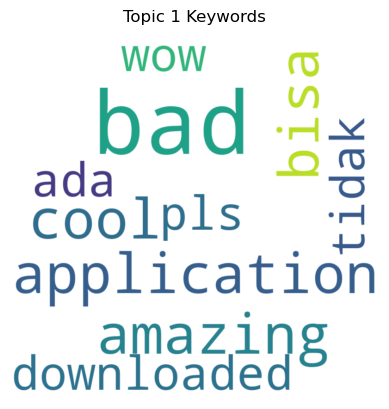

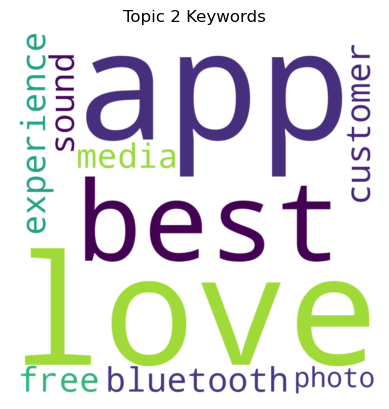

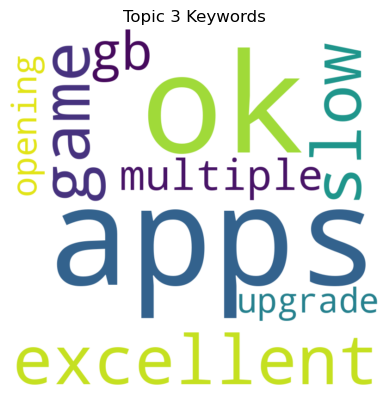

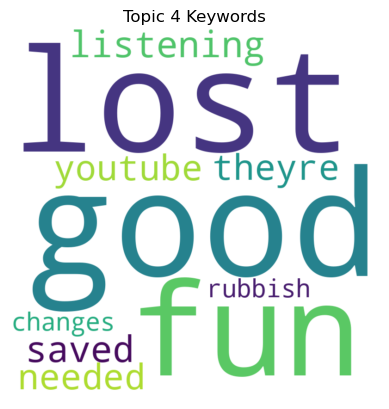

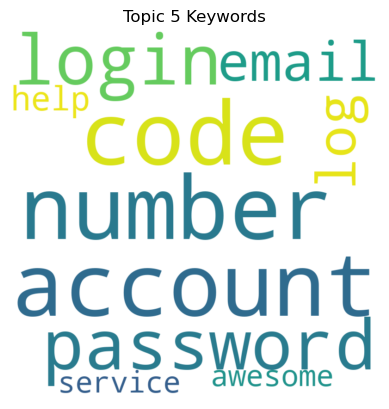

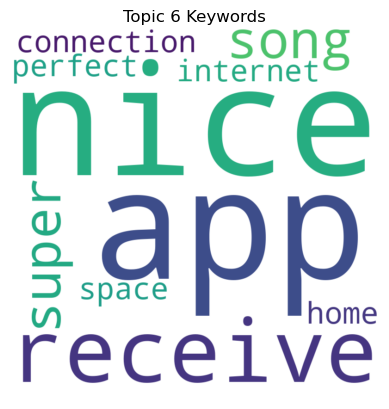

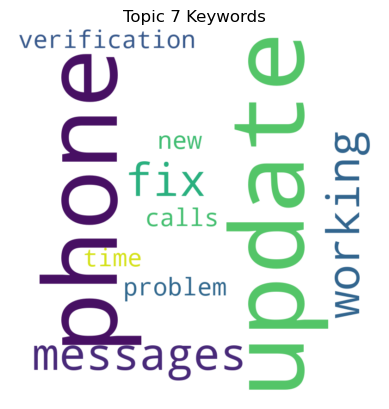

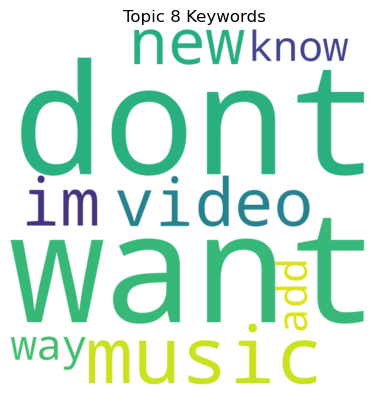

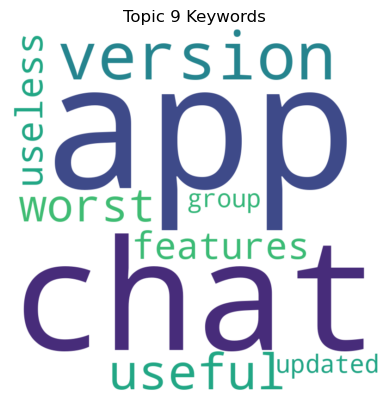

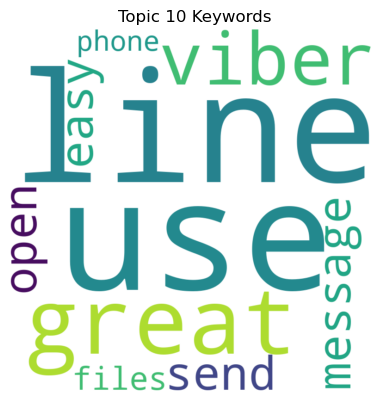

In [12]:
# Visualize the top keywords using a word cloud
for i, keywords in topic_keywords.items():
    plt.figure()
    wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(' '.join(keywords))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {i+1} Keywords')
    plt.show()

# Visualize the top keywords

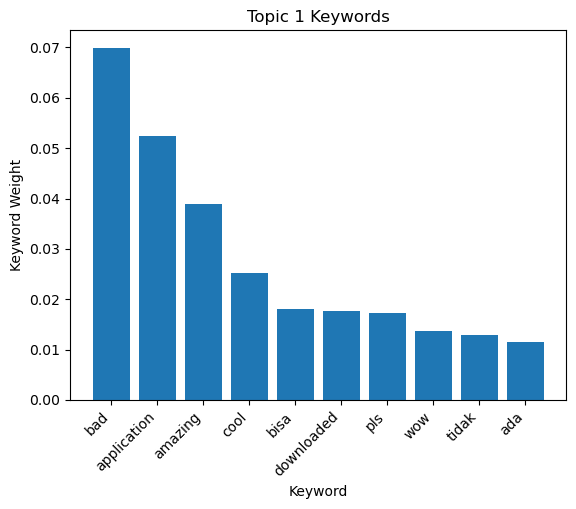

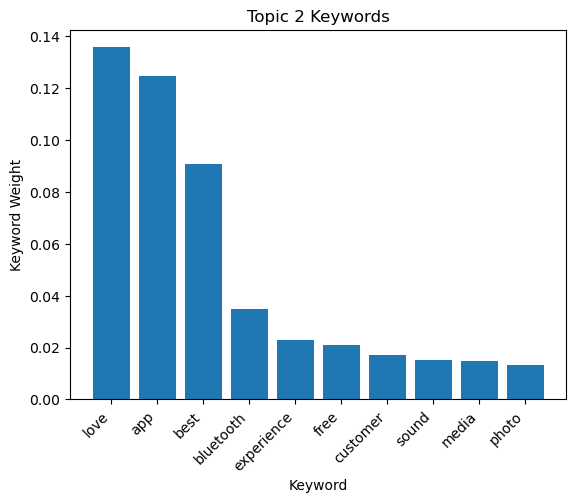

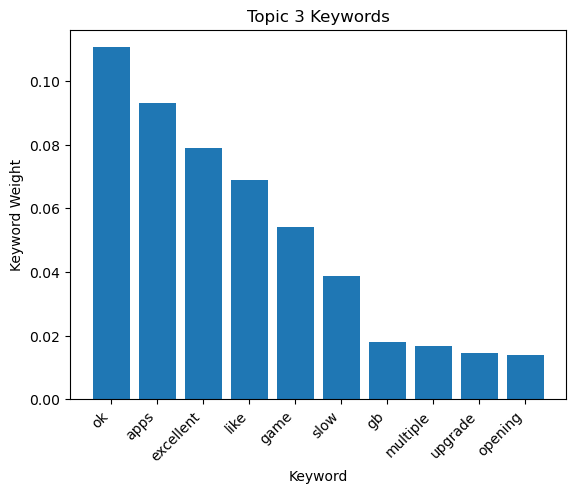

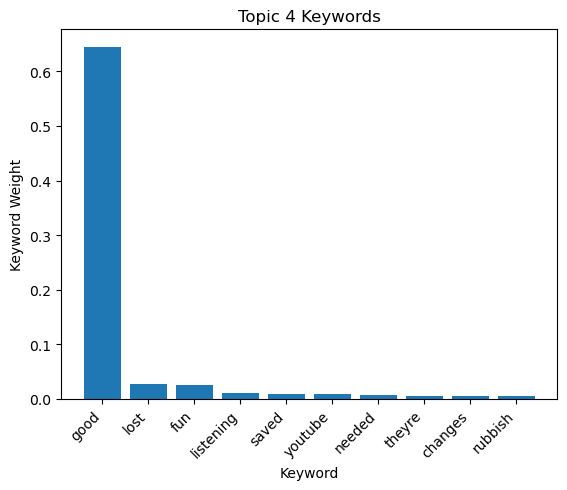

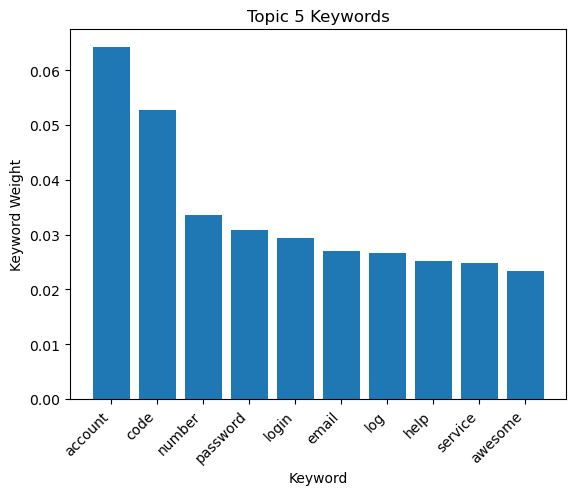

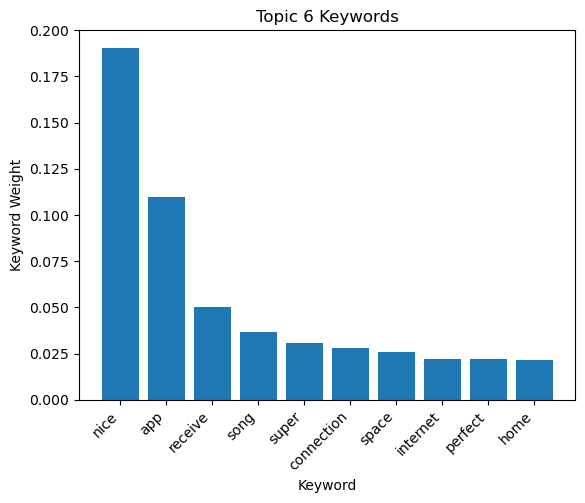

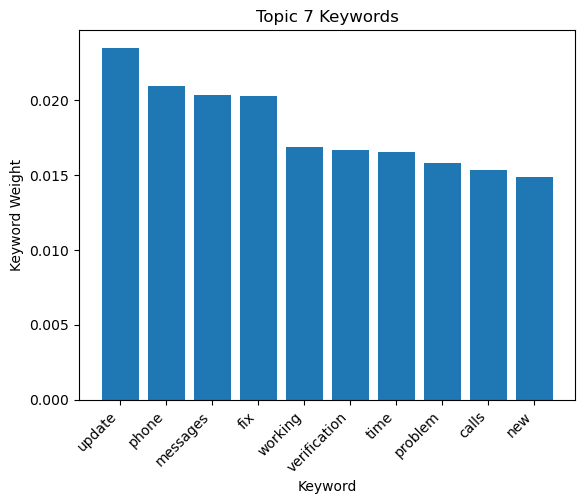

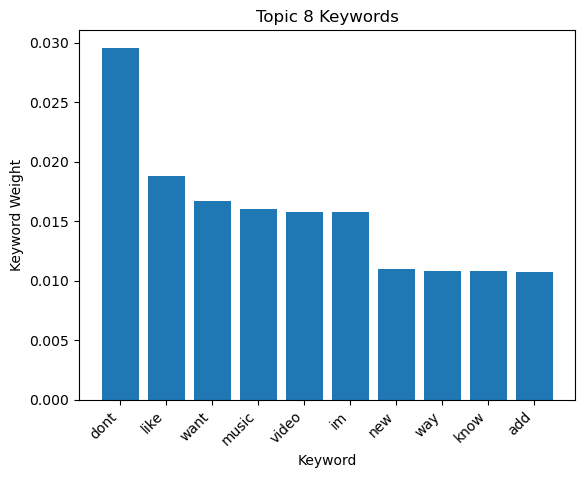

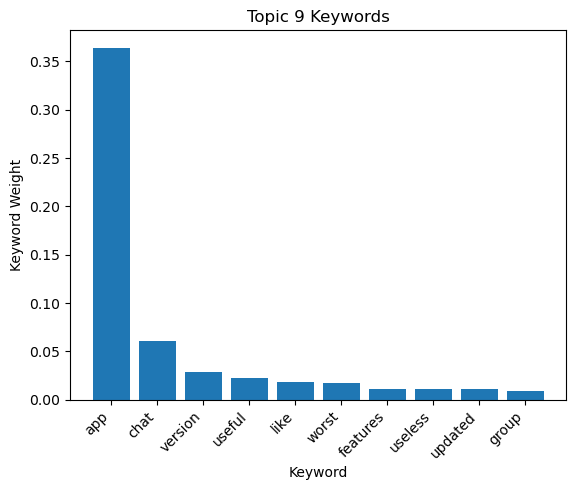

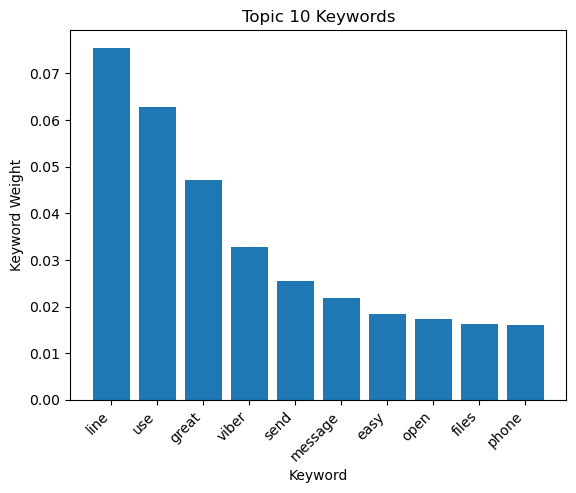

In [13]:
# Visualize the top keywords using a bar chart
for i, keywords in topic_keywords.items():
    plt.figure()
    plt.bar(range(len(keywords)), [word[1] for word in lda_model.show_topic(i, num_keywords)])
    plt.xticks(range(len(keywords)), keywords, rotation=45, ha='right')
    plt.title(f'Topic {i+1} Keywords')
    plt.ylabel('Keyword Weight')
    plt.xlabel('Keyword')
    plt.show()

# Calculate the average sentiment score for each app

In [14]:
# Calculate the average sentiment score for each app
app_sentiment = df.groupby('app')['sentiment'].mean()

# Sort the apps by average sentiment score
app_sentiment = app_sentiment.sort_values(ascending=False)

# Print the apps in order of highest to lowest average sentiment score
print(app_sentiment)

app
Microsoft Word          0.466636
Microsoft PowerPoint    0.389234
TikTok                  0.337022
SHAREit                 0.335842
Viber                   0.333017
Spotify                 0.300540
WhatsApp                0.297092
Dropbox                 0.296075
Candy Crush Saga        0.282966
Instagram               0.276747
Facebook Lite           0.274153
Twitter                 0.262725
Netflix                 0.255160
Snapchat                0.246854
Facebook Messenger      0.242809
Facebook                0.217168
Skype                   0.202250
Flipboard               0.196716
Subway Surfers          0.189060
LINE                    0.146911
Name: sentiment, dtype: float64


# Create a VADER sentiment analyzer object

Based on the average sentiment scores, it appears that Microsoft Word has the best positive sentiment, followed by Microsoft PowerPoint, TikTok, and SHAREit. The app with the lowest average sentiment score is LINE. 

In [15]:
# Create a VADER sentiment analyzer object
analyzer = SentimentIntensityAnalyzer()

# Define a function to calculate the sentiment scores for a given text
def get_sentiment_scores(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']

# Apply the function to the 'content' column to get the sentiment scores for each review
df['sentiment_scores'] = df['content'].apply(get_sentiment_scores)

# Calculate the average sentiment score for each app
app_sentiment = df.groupby('app')['sentiment_scores'].mean()

# Sort the apps by average sentiment score
app_sentiment = app_sentiment.sort_values(ascending=False)

# Print the apps in order of highest to lowest average sentiment score
print(app_sentiment)

app
Candy Crush Saga        0.404692
Microsoft Word          0.389205
Subway Surfers          0.376787
Microsoft PowerPoint    0.325874
TikTok                  0.309372
Viber                   0.271942
SHAREit                 0.269371
Spotify                 0.268838
Dropbox                 0.255402
WhatsApp                0.228567
Netflix                 0.223370
Instagram               0.218816
Facebook Lite           0.217266
Snapchat                0.212041
Twitter                 0.200169
Facebook Messenger      0.179739
Skype                   0.162385
Facebook                0.162383
Flipboard               0.160491
LINE                    0.103404
Name: sentiment_scores, dtype: float64


The output shows the average sentiment scores for each app based on the VADER sentiment analysis library. According to the results, Candy Crush Saga has the highest average sentiment score, followed by Microsoft Word, and Subway Surfers. LINE has the lowest average sentiment score.

# Comparison of Average and VADER Sentiment Scores by App

In [16]:
# Create a dataframe of the average sentiment scores
avg_sentiment_df = pd.DataFrame(app_sentiment).reset_index()
avg_sentiment_df = avg_sentiment_df.rename(columns={'app': 'App', 'sentiment_scores': 'Average Sentiment'})

# Create a dataframe of the VADER sentiment scores
vader_sentiment_df = df.groupby('app')['sentiment_scores'].mean().reset_index()
vader_sentiment_df = vader_sentiment_df.rename(columns={'app': 'App', 'sentiment_scores': 'VADER Sentiment'})

# Merge the two dataframes
merged_df = pd.merge(avg_sentiment_df, vader_sentiment_df, on='App')

# Create a bar chart
fig = px.bar(merged_df, x='App', y=['Average Sentiment', 'VADER Sentiment'], barmode='group')

# Add axis labels and a title
fig.update_layout(xaxis_title='App', yaxis_title='Sentiment Score', title='Comparison of Average and VADER Sentiment Scores by App')

# Show the chart
fig.show()

# Sentiment Mismatch 😨

In [17]:
# Create a new column indicating whether the sentiment column matches the sentiment score
df['sentiment_match'] = np.where(df['sentiment_scores'] > 0, df['sentiment'] > 0, df['sentiment'] < 0)

# Calculate the percentage of rows where the sentiment column matches the sentiment score
match_percentage = (df['sentiment_match'].sum() / len(df)) * 100

# Print the percentage of rows where the sentiment column matches the sentiment score
print(f"Percentage of rows where sentiment column matches sentiment score: {match_percentage:.2f}%")


Percentage of rows where sentiment column matches sentiment score: 59.72%


In [18]:
mismatched_rows = df.loc[(df['sentiment'] > 0) != (df['sentiment_scores'] > 0)]
mismatched_rows

reviewId  \
6       0865a334-7395-4d16-843a-f224adb567bd   
7       d9490b2d-8391-4f94-ae0e-43ba557b807f   
13      d055b22f-2a31-43d0-9ab0-174a8a7b2dca   
27      583665ea-cdaf-4836-a2d3-94bce3e8b7a6   
29      7f76e903-a26a-4b81-9c26-e01fd8e74837   
...                                      ...   
199975  7dafde92-fa56-4baa-b126-e060a17159b0   
199978  00f6d308-fe57-4399-bcd7-7c5e6e7100c4   
199979  d9118d91-4461-4739-b6a4-7c968892d656   
199989  4c0bef86-ad81-4af9-8469-41b50fb39db7   
199990  78e264d6-4213-40c9-818b-14736f80bbf7   

                                                  content  score       app  \
6       Dndvd xbdjsgeggmdb fbsvdnhz dnshx dnsbs s dndb...      5  Facebook   
7        Tell me facebook why cant i delete my 2nd number      1  Facebook   
13      To many adds, always being interrupted with ad...      1  Facebook   
27      Skibidi dob dob dob dob yes yes yes yes skib s...      1  Facebook   
29                                                God epp      3  Facebook   
...                                                   ...    ...       ...   
199975  Cannot sign in since I upgraded my phone.I tri...      1      LINE   
199978  Not bad. Rarely used. Requires 150 MB of space...      4      LINE   
199979                              Communication is fast      5      LINE   
199989  LINE is more of a online shop for selling stic...      3      LINE   
199990  FIX THE BACKGROUND RUNNING BUG! I can get noti...      1      LINE   

        sentiment                                             tokens  \
6        0.152381  [dndvd, xbdjsgeggmdb, fbsvdnhz, dnshx, dnsbs, ...   
7        0.000000               [tell, facebook, delete, nd, number]   
13       0.500000  [adds, interrupted, add, survey, getting, redi...   
27       0.000000  [skibidi, dob, dob, dob, dob, yes, yes, yes, y...   
29       0.000000                                         [god, epp]   
...           ...                                                ...   
199975   0.166667  [sign, upgraded, phonei, tried, sooo, times, v...   
199978   0.325000        [bad, rarely, requires, mb, space, reduced]   
199979   0.200000                              [communication, fast]   
199989   0.333333  [line, online, shop, selling, stickers, chat, ...   
199990   0.187500  [fix, background, running, bug, notifications,...   

        sentiment_scores  sentiment_match  
6                -0.0516            False  
7                 0.0772            False  
13               -0.2960            False  
27                0.8689            False  
29                0.2732            False  
...                  ...              ...  
199975           -0.1633            False  
199978           -0.5423            False  
199979            0.0000            False  
199989            0.0000            False  
199990           -0.2714            False  

[25356 rows x 8 columns]

In [19]:
def investigate_mismatched_rows(df):
    # Create a new column indicating whether the sentiment column matches the sentiment score
    df['sentiment_match'] = np.where(df['sentiment_scores'] > 0, df['sentiment'] > 0, df['sentiment'] < 0)

    # Get the rows where the sentiment column does not match the sentiment score
    mismatched_rows = df[df['sentiment_match'] == False]

    # Drop the sentiment_match column
    mismatched_rows = mismatched_rows.drop(columns=['sentiment_match'])

    return mismatched_rows

In [20]:
mismatched_rows = df[df['sentiment'] != df['sentiment_scores']]
print(mismatched_rows)

                                    reviewId  \
0       ad79684f-5763-4cc4-b730-a664c56917f5   
1       7413ce9a-5fdb-43fe-885e-d7e97e6f74dd   
4       f8b343c0-c587-4eda-b22c-4a09f7760e11   
6       0865a334-7395-4d16-843a-f224adb567bd   
7       d9490b2d-8391-4f94-ae0e-43ba557b807f   
...                                      ...   
199992  8c32c3ba-c22f-4b73-babc-da122bb00e8f   
199993  b0c67681-43b6-41de-9775-00a091f73ffd   
199994  63e277d9-3e7a-47cc-b5cf-0f5bccbd8cf6   
199996  d9959de4-802b-426c-8030-4df0df5a3392   
199999  88796319-f40f-4170-8c2a-6e9a797b9006   

                                                  content  score       app  \
0                                                Nice app      3  Facebook   
1                                                    Nice      5  Facebook   
4        I am very poor butt this app is my future career      5  Facebook   
6       Dndvd xbdjsgeggmdb fbsvdnhz dnshx dnsbs s dndb...      5  Facebook   
7        Tell me facebook why can

Based on the results of the sentiment analysis and the comparison between the sentiment and sentiment_scores columns, we can see that the sentiment_scores column gives a more accurate representation of the sentiment of each review. Therefore, it may be a good idea to drop the sentiment column and keep the sentiment_scores column.

Regarding the tokens column, it may be useful for certain types of analyses, but for sentiment analysis purposes, it is not necessary. We can drop this column as well.

Finally, the processed_text column may be useful if we want to perform further text processing on the reviews, such as removing stop words or stemming. However, for the purpose of sentiment analysis, it is not necessary. We can drop this column as well.

Therefore, we can drop the sentiment, tokens, and processed_text columns from the DataFrame.

In [21]:
df

reviewId  \
0       ad79684f-5763-4cc4-b730-a664c56917f5   
1       7413ce9a-5fdb-43fe-885e-d7e97e6f74dd   
2       89d84e8d-edb4-4953-ad51-21a4e6e2c860   
3       69d2af5c-2e31-4f11-9afa-6af656bef5bc   
4       f8b343c0-c587-4eda-b22c-4a09f7760e11   
...                                      ...   
199995  a37c74b3-b509-4bf4-8fd4-530185c27e8c   
199996  d9959de4-802b-426c-8030-4df0df5a3392   
199997  61ade8d1-c3b2-4215-a3d4-bc89362dbbc1   
199998  def21317-563c-4b14-9fb5-70f27b64e773   
199999  88796319-f40f-4170-8c2a-6e9a797b9006   

                                                  content  score       app  \
0                                                Nice app      3  Facebook   
1                                                    Nice      5  Facebook   
2                                           Joss app🌸☺️💖✨      5  Facebook   
3                               Rnju Rnju 12345-789 Bcdgh      4  Facebook   
4        I am very poor butt this app is my future career      5  Facebook   
...                                                   ...    ...       ...   
199995                                           علشانه n      5      LINE   
199996  It's a great place to communicate with my gami...      5      LINE   
199997  Yhftyxtgct5 vaccination tetap ttfttþu ycþyttRe...      3      LINE   
199998  เมื่อไหร่จะทำให้ 1 user ใช้ได้หลายเครื่อง คนใช...      1      LINE   
199999           5 star, Easy to use and free and instant      5      LINE   

        sentiment                                             tokens  \
0        0.600000                                        [nice, app]   
1        0.600000                                             [nice]   
2        0.000000                                        [joss, app]   
3        0.000000                                [rnju, rnju, bcdgh]   
4       -0.260000                  [poor, butt, app, future, career]   
...           ...                                                ...   
199995   0.000000                                                 []   
199996   0.800000       [great, place, communicate, gaming, friends]   
199997   0.000000  [yhftyxtgct, vaccination, tetap, ttfttu, ycytt...   
199998   0.000000                       [user, table, android, ipad]   
199999   0.277778                   [star, easy, use, free, instant]   

        sentiment_scores  sentiment_match  
0                 0.4215             True  
1                 0.4215             True  
2                 0.0000            False  
3                 0.0000            False  
4                -0.5256             True  
...                  ...              ...  
199995            0.0000            False  
199996            0.8020             True  
199997            0.0000            False  
199998            0.0000            False  
199999            0.7351             True  

[199988 rows x 8 columns]

In [22]:
df.drop(['sentiment_scores'], axis=1, inplace=True)

In [23]:
# Drop rows with mismatched sentiment
df = df[df['sentiment_match'] == True]

In [24]:
# Drop sentiment_match column
df = df.drop('sentiment_match', axis=1)

In [25]:
df

reviewId  \
0       ad79684f-5763-4cc4-b730-a664c56917f5   
1       7413ce9a-5fdb-43fe-885e-d7e97e6f74dd   
4       f8b343c0-c587-4eda-b22c-4a09f7760e11   
8       22017744-8f2a-44bd-adbf-dc05460d4395   
9       49196792-3d7b-46f1-a2b4-e89f8c00131d   
...                                      ...   
199992  8c32c3ba-c22f-4b73-babc-da122bb00e8f   
199993  b0c67681-43b6-41de-9775-00a091f73ffd   
199994  63e277d9-3e7a-47cc-b5cf-0f5bccbd8cf6   
199996  d9959de4-802b-426c-8030-4df0df5a3392   
199999  88796319-f40f-4170-8c2a-6e9a797b9006   

                                                  content  score       app  \
0                                                Nice app      3  Facebook   
1                                                    Nice      5  Facebook   
4        I am very poor butt this app is my future career      5  Facebook   
8                                                    Nice      5  Facebook   
9       The problem with reading comments in videos is...      3  Facebook   
...                                                   ...    ...       ...   
199992  Bad. Always unable to send message like everyt...      1      LINE   
199993  If it ain't broke, don't fix it..... The stick...      1      LINE   
199994  Line has been great the past 5 years but now I...      1      LINE   
199996  It's a great place to communicate with my gami...      5      LINE   
199999           5 star, Easy to use and free and instant      5      LINE   

        sentiment                                             tokens  
0        0.600000                                        [nice, app]  
1        0.600000                                             [nice]  
4       -0.260000                  [poor, butt, app, future, career]  
8        0.600000                                             [nice]  
9       -0.483333  [problem, reading, comments, videos, click, re...  
...           ...                                                ...  
199992  -0.850000  [bad, unable, send, message, like, everytime, ...  
199993   0.100000  [aint, broke, dont, fix, sticker, brokenthe, s...  
199994   0.183333  [line, great, past, years, use, wifi, works, u...  
199996   0.800000       [great, place, communicate, gaming, friends]  
199999   0.277778                   [star, easy, use, free, instant]  

[119433 rows x 6 columns]

# Get the top features mentioned in the reviews

In [26]:
# Get the top features mentioned in the reviews
top_features = df['content'].str.findall(r'\w{3,}').explode().value_counts().head(20)

# Create a dataframe of the top features
top_features_df = pd.DataFrame({'Feature': top_features.index, 'Count': top_features.values})

# Create a horizontal bar chart
fig = px.bar(top_features_df, x='Count', y='Feature', orientation='h')

# Add axis labels and a title
fig.update_layout(xaxis_title='Count', yaxis_title='Feature', title='Top Features Mentioned in Reviews')

# Show the chart
fig.show()


## We investigated the dataset contains almost 40 % rows which are mismatched with sentiment hence its advisable to recheck the entry from the data collection point of view. This is just a suggestion further investigation and revamp will continue from the remaining files. 🤔